# I2P-Analyse über eine HTTP-Anfrage

In [1]:
!pip install scapy matplotlib numpy pandas scipy scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from scapy.all import rdpcap

frame_nr = [97115, 97119, 97120, 97144, 97145, 97146, 97192]
packets = rdpcap('traffic.pcap')

In [3]:
from scapy.all import IP, TCP, UDP, Raw
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import entropy

frame_indices = [i - 1 for i in frame_nr]
filtered_packets = [packets[i] for i in frame_indices if i < len(packets)]

for i, pkt in zip(frame_nr, filtered_packets):
    print(f"Frame {i}: {pkt.summary()}")

Frame 97115: CookedLinuxV2 / IP / TCP 10.8.0.2:18202 > 10.8.0.11:48395 PA / Raw
Frame 97119: CookedLinuxV2 / IP / UDP 10.8.0.11:9156 > 10.8.0.3:10661 / Raw
Frame 97120: CookedLinuxV2 / IP / UDP 10.8.0.11:9156 > 10.8.0.3:10661 / Raw
Frame 97144: CookedLinuxV2 / IP / UDP 10.8.0.3:10661 > 10.8.0.11:9156 / Raw
Frame 97145: CookedLinuxV2 / IP / UDP 10.8.0.3:10661 > 10.8.0.11:9156 / Raw
Frame 97146: CookedLinuxV2 / IP / TCP 10.8.0.3:35817 > 10.8.0.6:10166 PA / Raw
Frame 97192: CookedLinuxV2 / IP / TCP 10.8.0.6:10166 > 10.8.0.5:37237 PA / Raw


## Entropie-Analyse (Payload)

Eine hohe Entropie deutet auf eine starke Verschlüsselung hin.

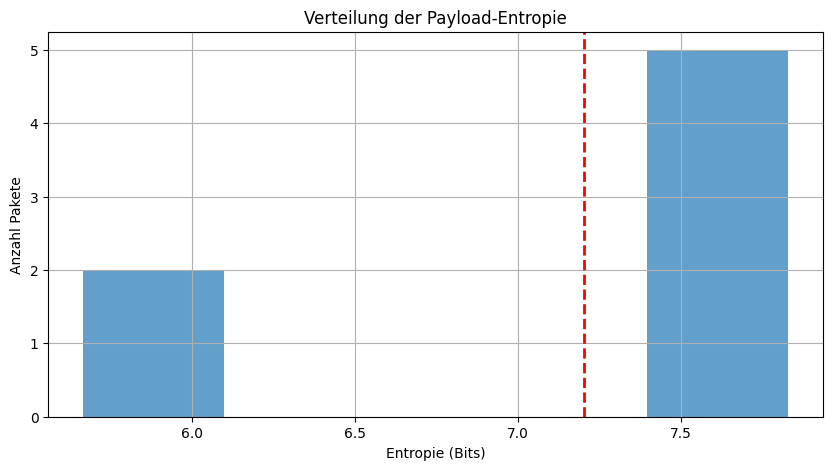


Durchschnittliche Entropie: 7.2015 Bits
Frame Nr. | Entropie (Bits) | Payload-Grösse (Bytes)
----------|------------------|------------------------
    97115 |           7.8270 |                   1066
    97119 |           7.8233 |                   1094
    97120 |           7.8233 |                   1094
    97144 |           5.6668 |                     67
    97145 |           5.6668 |                     67
    97146 |           7.7953 |                   1081
    97192 |           7.8083 |                   1069

Bin-Bereich (von - bis)       | Anzahl Pakete
--------------------------------|----------------
  5.6668 -   6.0988       |              2
  6.0988 -   6.5309       |              0
  6.5309 -   6.9629       |              0
  6.9629 -   7.3950       |              0
  7.3950 -   7.8270       |              5


In [4]:
show_details = True


def calc_entropy(data):
    if not data:
        return 0
    counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    return entropy(counts, base=2)


# Entropie + Payload-Grösse berechnen
packet_info = []
for frame_id, pkt in zip(frame_nr, filtered_packets):
    if Raw in pkt:
        payload = bytes(pkt[Raw].load)
        ent = calc_entropy(payload)
        packet_info.append((frame_id, ent, len(payload)))
    else:
        packet_info.append((frame_id, None, 0))  # Kein Payload

# Nur gültige Entropien für Histogramm
entropies = [ent for _, ent, _ in packet_info if ent is not None]
mean_entropy = np.mean(entropies)

plt.figure(figsize=(10, 5))
plt.axvline(mean_entropy, color='red', linestyle='dashed', linewidth=2, label=f'Mittelwert: {mean_entropy:.2f} Bits')
counts, bin_edges, _ = plt.hist(entropies, bins=5, alpha=0.7)
plt.xlabel('Entropie (Bits)')
plt.ylabel('Anzahl Pakete')
plt.title('Verteilung der Payload-Entropie')
plt.grid(True)
plt.show()

# Sortieren nach Frame-Nr.
packet_info.sort(key=lambda x: x[0])

if show_details:
    print("\nDurchschnittliche Entropie: {:.4f} Bits".format(mean_entropy))
    print("Frame Nr. | Entropie (Bits) | Payload-Grösse (Bytes)")
    print("----------|------------------|------------------------")
    for frame_id, ent, payload_size in packet_info:
        if ent is not None:
            print(f"{frame_id:9} | {ent:16.4f} | {payload_size:>22}")
        else:
            print(f"{frame_id:9} | {'Kein Payload':>16} | {payload_size:>22}")

    print("\nBin-Bereich (von - bis)       | Anzahl Pakete")
    print("--------------------------------|----------------")
    for i in range(len(counts)):
        start = bin_edges[i]
        end = bin_edges[i + 1]
        count = int(counts[i])
        print(f"{start:8.4f} - {end:8.4f}       | {count:>14}")


# Analyse der Payload-Grösse pro Netzwerkpaket

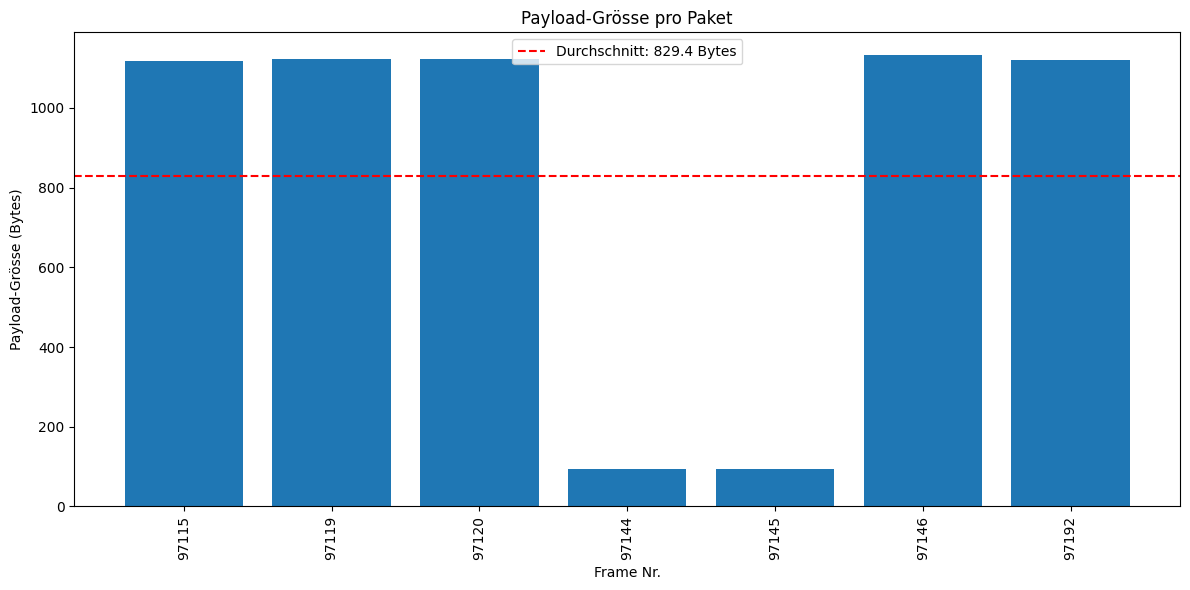

Gesamte Payload-Grösse: 5806 Bytes
Durchschnittliche Payload-Grösse: 829.4 Bytes


In [5]:
import numpy as np
import matplotlib.pyplot as plt

if not filtered_packets:
    print("Keine Pakete vorhanden.")
else:
    payload_sizes = []
    frame_ids = []
    for frame_id, pkt in zip(frame_nr, filtered_packets):
        payload_size = len(pkt.payload)
        payload_sizes.append(payload_size)
        frame_ids.append(str(frame_id))

    total_payload = sum(payload_sizes)
    avg_payload_size = float(np.mean(payload_sizes)) if payload_sizes else 0.0

    plt.figure(figsize=(max(12, len(frame_ids) * 0.4), 6))
    plt.bar(frame_ids, payload_sizes)
    plt.axhline(avg_payload_size, color='red', linestyle='--', label=f'Durchschnitt: {avg_payload_size:.1f} Bytes')
    plt.xlabel("Frame Nr.")
    plt.ylabel("Payload-Grösse (Bytes)")
    plt.title("Payload-Grösse pro Paket")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Gesamte Payload-Grösse: {} Bytes".format(total_payload))
    print("Durchschnittliche Payload-Grösse: {:.1f} Bytes".format(avg_payload_size))


# Kosinus-Ähnlichkeit zwischen den Payloads

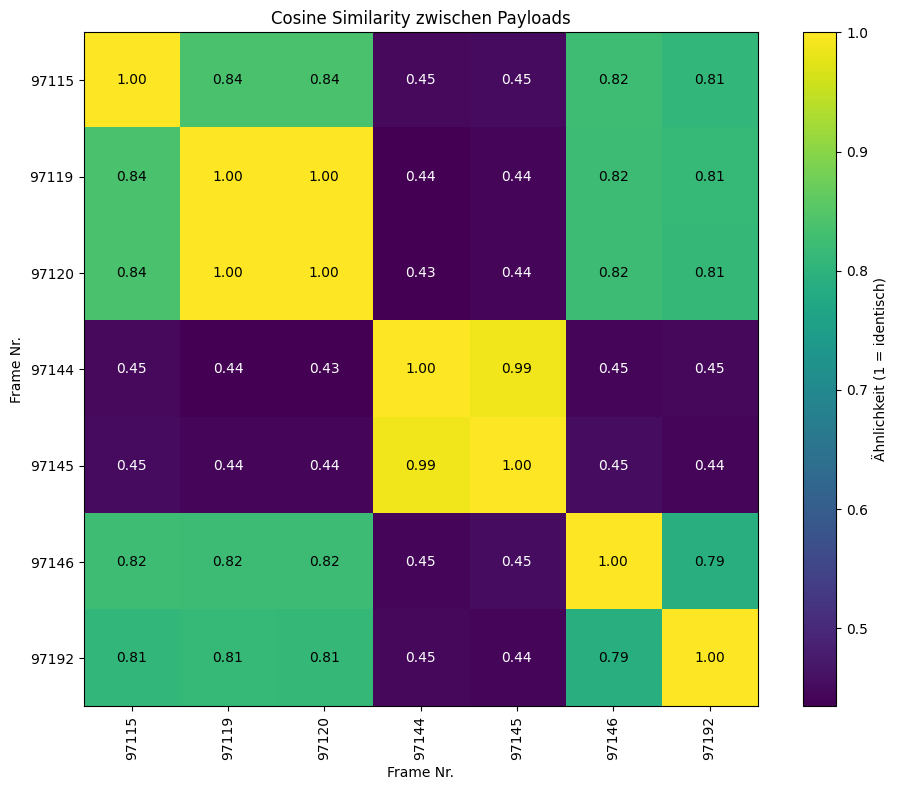

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


# Erstellen eines 256-dimensionalen Histogramm
def payload_to_hist(payload):
    vec = np.zeros(256, dtype=int)
    for byte in payload:
        vec[byte] += 1
    return vec


if not filtered_packets:
    print("Keine Pakete vorhanden.")
else:
    histograms = []
    labels = []
    # Für jedes Paket das Histogramm erstellen
    for frame_id, pkt in zip(frame_nr, filtered_packets):
        payload = bytes(pkt.payload)
        histograms.append(payload_to_hist(payload))
        labels.append(str(frame_id))

    histogram_matrix = np.array(histograms)
    similarity_matrix = cosine_similarity(histogram_matrix)

    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.imshow(similarity_matrix, cmap='viridis')
    ax.set_title("Kosinus-Ähnlichkeit zwischen Payloads")
    ax.set_xlabel("Frame Nr.")
    ax.set_ylabel("Frame Nr.")
    plt.colorbar(cax, label="Ähnlichkeit (1 = identisch)")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            value = similarity_matrix[i, j]
            ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="white" if value < 0.5 else "black")

    plt.tight_layout()
    plt.show()